The first step in this project will be to calibrate the camera. The code below set's this up. The images of a chessboard are used to calibrate the camera. 

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
%matplotlib inline
save_path = 'output_images'

# Number of corners in the x and y planes
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    print (img.shape)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    print (gray.shape)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


(720, 1280, 3)
(720, 1280)
(720, 1280, 3)
(720, 1280)
(720, 1280, 3)
(720, 1280)
(720, 1280, 3)
(720, 1280)
(721, 1281, 3)
(721, 1281)
(720, 1280, 3)
(720, 1280)
(720, 1280, 3)
(720, 1280)
(720, 1280, 3)
(720, 1280)
(720, 1280, 3)
(720, 1280)
(720, 1280, 3)
(720, 1280)
(721, 1281, 3)
(721, 1281)
(720, 1280, 3)
(720, 1280)
(720, 1280, 3)
(720, 1280)
(720, 1280, 3)
(720, 1280)
(720, 1280, 3)
(720, 1280)
(720, 1280, 3)
(720, 1280)
(720, 1280, 3)
(720, 1280)
(720, 1280, 3)
(720, 1280)
(720, 1280, 3)
(720, 1280)
(720, 1280, 3)
(720, 1280)


Now create functions that will allow images from the camera to be manipulated 

In [3]:
def undistort(img,objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def perspective_transform(img):
    src = np.float32([[220,700],[595,450],[686,450],[1090,700]])
    dst = np.float32([[200,700],[220,100],[1000,100],[1000,700]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    return warped ,  Minv

def threshold(img, s_thresh=(100, 255), sx_thresh=(20, 255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0,ksize=5)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1,ksize=5)
    abs_sobely = np.absolute(sobely)
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobelx))
    sy_binary = np.zeros_like(scaled_sobely)
    sy_binary[(scaled_sobely >= 20) & (scaled_sobely <= 255)] = 1
    
    # Threshold color channel
    #Note L Thresholds are 150 and 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= 150) & (l_channel <= 200)] = 1
    # Stack each channel 

    cx_binary = np.zeros_like(s_channel)
    cx_binary[((s_binary == 1)&(l_binary == 1))|((sy_binary == 1)&(sx_binary == 1))|((l_binary == 1)&(sy_binary == 1))] = 1
    
    return cx_binary*255

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 150
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### Finds the four below boundaries of the window 
        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin  
        win_xright_low = rightx_current - margin  
        win_xright_high = rightx_current + margin  
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
          
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
      
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        
        #If found > minpix pixels, recenter next window ###
        if(len(good_left_inds) > minpix):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
        if(len(good_right_inds) > minpix):
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    if(1):
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
    else:
        print ("Points not found")

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fits a second order polynomial to each
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
   
    left_curverad, right_curverad, avg_curv, Offset = measure_curvature_real(left_fitx,right_fitx,ploty) 
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit, ploty, left_fitx, right_fitx, avg_curv, Offset, left_curverad, right_curverad

def measure_curvature_real(leftx,rightx,ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 40/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension
    y_base = 720*ym_per_pix
    left_fit = np.polyfit(ploty, leftx, 2)
    right_fit = np.polyfit(ploty, rightx, 2)
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)*ym_per_pix
    
    #Calculates the radius of curvature
    left_curverad = np.power(1+(2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2,1.5)/(2*left_fit_cr[0]) 
    right_curverad = np.power(1+(2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2,1.5)/(2*right_fit_cr[0]) 
    
    avg_curv = np.absolute((left_curverad+right_curverad)//2)
    
    #calculate the mid point between the curves at the bottom of the image 
    Left_Curve_Base = left_fit[0]*720**2+left_fit[1]*720+left_fit[2]
    Right_Curve_Base = right_fit[0]*720**2+right_fit[1]*720+right_fit[2]
    Center_Lane = (Left_Curve_Base+Right_Curve_Base)//2
    Offset = round((640 - Center_Lane) * xm_per_pix,2)
    
    return left_curverad, right_curverad,avg_curv, Offset

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    #Fits a second order polynomial to each
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    #Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
    
    left_curverad, right_curverad, avg_curv, Offset = measure_curvature_real(left_fitx,right_fitx,ploty)
    
    return left_fitx, right_fitx, ploty, avg_curv, Offset, left_fit, right_fit, left_curverad, right_curverad

def search_around_poly(binary_warped,left_fit,right_fit):
    # HYPERPARAMETER
    margin = 50

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #Set the area of search based on activated x-values ###
    good_left_inds = []
    good_right_inds = []
    for index in range (len(nonzeroy)):
        if((nonzerox[index]>=((left_fit[0]*nonzeroy[index]**2)+left_fit[1]*nonzeroy[index]+left_fit[2])-margin)&(nonzerox[index]<((left_fit[0]*nonzeroy[index]**2)+left_fit[1]*nonzeroy[index]+left_fit[2])+margin)):
                    good_left_inds.append(index)
        elif ((nonzerox[index]>=((right_fit[0]*nonzeroy[index]**2)+right_fit[1]*nonzeroy[index]+right_fit[2])-margin)&(nonzerox[index]<((right_fit[0]*nonzeroy[index]**2)+right_fit[1]*nonzeroy[index]+right_fit[2])+margin)):
                    good_right_inds.append(index)
    
        
    left_lane_inds = good_left_inds
    right_lane_inds = good_right_inds
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, avg_curv, Offset, left_fit, right_fit, left_curverad, right_curverad = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return result, avg_curv, Offset, left_fitx, right_fitx, ploty, left_fit, right_fit, left_curverad, right_curverad


In [4]:
#Sanity check function and tracking over multiple frames 
# Define a class to receive the characteristics of each line detection
def Curv_Sanity(Left_Line,Right_Line,curv_avg):
    #if curvature if very large for both lines, and the lines are parallel, than the road is straight
    #if((np.absolute(Right_Line.rad_of_curv)*0.5<=np.absolute(Left_Line.rad_of_curv)<=np.absolute(Right_Line.rad_of_curv)*1.5)):   
    if((np.absolute(Left_Line.rad_of_curv)>3000)&(np.absolute(Right_Line.rad_of_curv)>3000)):
        return True, True
    
    #if the lines are in the same direction, parallel and the previous average of the curves is within margin to the current, the lines are ok
    if((Left_Line.rad_of_curv*Right_Line.rad_of_curv)>0):
        if((np.absolute(Right_Line.rad_of_curv)*0.7<=np.absolute(Left_Line.rad_of_curv)<=np.absolute(Right_Line.rad_of_curv)*1.3)):
            #if((Left_Line.curv_avg*0.75<curv_avg<Left_Line.curv_avg*1.25)):
            return True, True
        else:
            return False, False
    else:
        return False, False
    
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.rad_of_curv = None 
        self.rad_of_curv_list = []
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 
        #Check Variables 
        self.recheck = True #flag to reset and use sliding windows 
        self.errorCount = 0 #counter that triggers the recheck flag to be set 
        self.good_counter = 0 #counts n iterations of good images 
        self.curv_avg = 0 
        self.first = False 


Here is the image pipeline for static images. This block is used to experiment on code with 

sliding window
[  6.01731523e-04  -8.70331191e-01   4.90625747e+02]  and  [  9.72726725e-04  -1.19276501e+00   1.41537340e+03]
448.0
search around
557.0
List is:  [554.51156461732569]
Length is 1


True

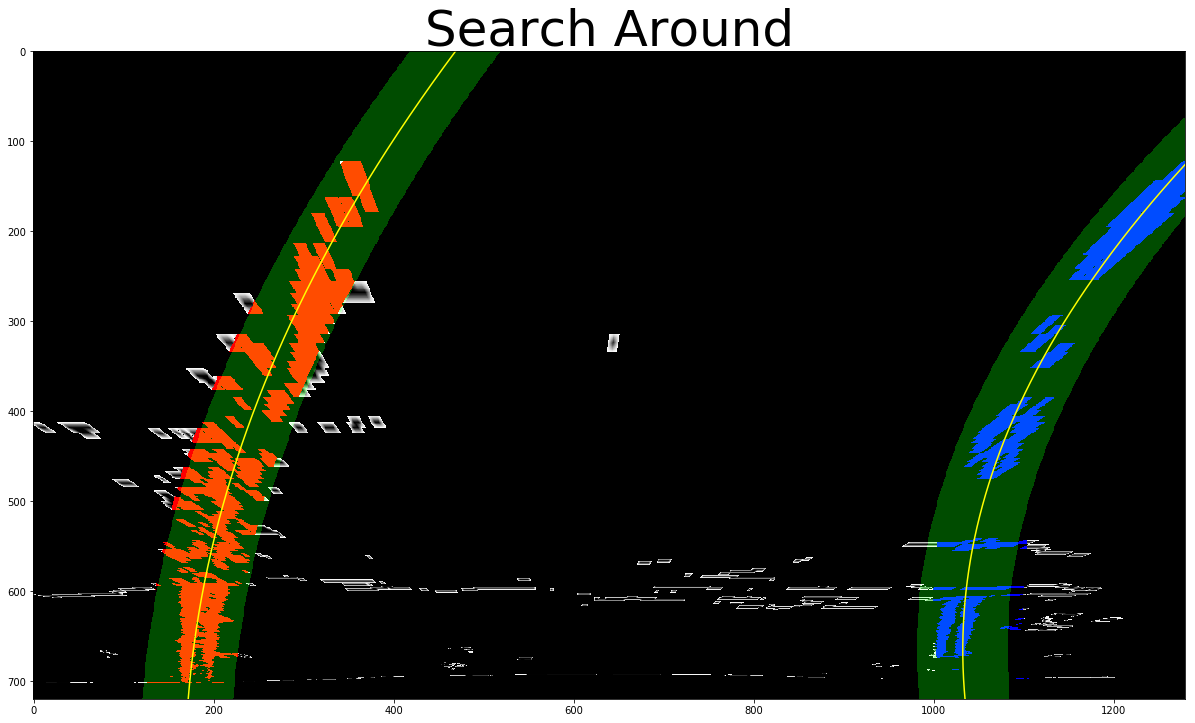

In [80]:
images = glob.glob('test_images/*.jpg') #grab all images in folder 
img = cv2.imread(images[2])#set the image to be analyzed

#cal_image =  cv2.imread('camera_cal/calibration1.jpg')
#cal_undistort = undistort(cal_image, objpoints, imgpoints)
#cv2.imwrite(os.path.join(save_path , 'Cal_Image_Undistort.jpg'), cal_undistort)

#create object Line for Left and Right lane 
Left_Line = Line()
Right_Line = Line()
#Undistort the image 3
unD = undistort(img,objpoints, imgpoints)
#cv2.imwrite(os.path.join(save_path , 'Undistored6.jpg'), unD)
#Apply Thresholding to the image 
warpedu, Minv= perspective_transform(unD)
threshu = threshold(warpedu)
thresh = threshold(unD)
#cv2.imwrite(os.path.join(save_path , 'Thresh6.jpg'), thresh)
#Perform a perspective transform 
warped, Minv= perspective_transform(thresh)
warped2, Minv= perspective_transform(thresh)
#cv2.imwrite(os.path.join(save_path , 'Warped6.jpg'), warped)



#Set plots for images that are output 
f, (ax1) = plt.subplots(1, 1, figsize=(27, 10))
f.tight_layout()
#cv2.line(unD, (220, 700), (592, 450), [255, 0, 0], 2)
#cv2.line(unD, (1100, 700), (692, 450), [255, 0, 0], 2)
ax1.imshow(unD)
ax1.set_title('Search Around', fontsize=50)
#cv2.line(warped, (200, 700), (200, 100), [255, 255, 0], 2)
#cv2.line(warped, (1000, 700), (1000, 100), [255, 255, 0], 2)
#ax2.imshow(thresh)
#ax2.set_title('Image 2', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#ax3.imshow(warped)
#ax4.imshow(warped2)
#thresh = warpedu
#warped = threshu

recheck = True #flag to reset and use sliding windows 
errorCount = 0 #counter that triggers the recheck flag to be set 
good_counter = 0 
#out_img, Left_Line.current_fit, Right_Line.current_fit, ploty, left_fitx, right_fitx, curv_avg, Offset, Left_Line.rad_of_curv, Right_Line.rad_of_curv = fit_polynomial(warped)
#fit a polynomial using the sliding windows method 
for two in range (2):
    if((not(Left_Line.detected&Right_Line.detected) == True) & recheck == True):
        print ("sliding window")
        out_img, Left_Line.current_fit, Right_Line.current_fit, ploty, left_fitx, right_fitx, curv_avg, Offset, Left_Line.rad_of_curv, Right_Line.rad_of_curv = fit_polynomial(warped)
        print(Left_Line.current_fit," and ",Right_Line.current_fit)
        #Check if the lines detected are valid. If they are, set valid flag and on next iteration, use search around 
        Left_Line.rad_of_curv_list.append(Left_Line.rad_of_curv)
        Right_Line.rad_of_curv_list.append(Right_Line.rad_of_curv)
        
        Left_Line.detected, Right_Line.detected = Curv_Sanity(Left_Line,Right_Line,curv_avg)
        Left_Line.best_fit = Left_Line.current_fit
        Right_Line.best_fit = Right_Line.current_fit
        good_counter += 1
        recheck = False

        cv2.imwrite(os.path.join(save_path , 'Sliding0.jpg'), out_img)
        #ax1.imshow(out_img)
        print (curv_avg)
    else:
        print ("search around")
        #img = cv2.imread(images[0])
        #unD = undistort(img,objpoints, imgpoints)
        #thresh = threshold(unD)
        #warped2, Minv2 = perspective_transform(thresh)
        result,avg_curv2, OF2,left_fitx, right_fitx, ploty, Left_Line.current_fit, Right_Line.current_fit,Left_Line.rad_of_curv, Right_Line.rad_of_curv = search_around_poly(warped,Left_Line.current_fit,Right_Line.current_fit)
        Left_Line.detected, Right_Line.detected=Curv_Sanity(Left_Line,Right_Line,avg_curv2)
        if ((Left_Line.detected&Right_Line.detected) == False):
            errorCount += 1
        else:
            #average out the best fit with the previous best value 
            good_counter += 1
            Left_Line.best_fit[0] = (Left_Line.best_fit[0] + Left_Line.current_fit[0]) / good_counter
            Left_Line.best_fit[1] = (Left_Line.best_fit[1] + Left_Line.current_fit[1]) / good_counter
            Left_Line.best_fit[2] = (Left_Line.best_fit[2] + Left_Line.current_fit[2]) / good_counter
            Right_Line.best_fit[0] = (Right_Line.best_fit[0] + Right_Line.current_fit[0]) / good_counter
            Right_Line.best_fit[1] = (Right_Line.best_fit[1] + Right_Line.current_fit[1]) / good_counter
            Right_Line.best_fit[2] = (Right_Line.best_fit[2] + Right_Line.current_fit[2]) / good_counter


        if(errorCount > 3): 
            recheck = True 
            errorCount = 0
            good_counter = 0
        #Average out the best fit results. If line fails more than 3 times, reset to sliding windows 

        print (avg_curv2)
        cv2.imwrite(os.path.join(save_path , 'Search0.jpg'), result)
        ax1.imshow(result)
    
# To do - Take the best fit and find the points for it, Use that to find curvature that will be displayed 

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
font = cv2.FONT_HERSHEY_SIMPLEX
# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result2 = cv2.addWeighted(unD, 1, newwarp, 0.3, 0)


left_fitx = Left_Line.best_fit[0]*ploty**2+Left_Line.best_fit[1]*ploty+Left_Line.best_fit[2]
right_fitx = Right_Line.best_fit[0]*ploty**2+Right_Line.best_fit[1]*ploty+Right_Line.best_fit[2]
    
left_curverad, right_curverad, curv_avg, Offset = measure_curvature_real(left_fitx,right_fitx,ploty)

print ("List is: ",Left_Line.rad_of_curv_list)
print ("Length is",  len(Left_Line.rad_of_curv_list))
cv2.putText(result2,"Radius of Curvature is: "+str(curv_avg)+"m",(150,100), font, 2,(255,255,255),2,cv2.LINE_AA)
if(Offset > 0):
    cv2.putText(result2,"Vehicle is "+str(abs(Offset))+" left of center",(150,200), font, 2,(255,255,255),2,cv2.LINE_AA)
else:
    cv2.putText(result2,"Vehicle is "+str(abs(Offset))+" right of center",(150,200), font, 2,(255,255,255),2,cv2.LINE_AA)
cv2.imwrite(os.path.join(save_path , 'FinalOut_2.jpg'), result2)
#ax1.imshow(result2) 

#### Below the pipeline is used on actual videos 

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#Create Line variables for both lanes. Note left lane is also used to keep track
#of flags that determine when to use sliding window or search around and when to 
#reject lanes lines that were found. 
Left_Line = Line()
Right_Line = Line()

In [8]:
def process_image(image):
    #Undistort the image 
    unD = undistort(image,objpoints, imgpoints)
    #Apply Thresholding to the image 
    thresh = threshold(unD)
    #Perform a perspective transform 
    warped, Minv= perspective_transform(thresh)
    #Check if flags and parameters are set for sliding window, else use the search around method
    if((not(Left_Line.detected&Right_Line.detected) == True) & Left_Line.recheck == True):
        #call the fit polynomial function that uses sliding window 
        out_img, Left_Line.current_fit, Right_Line.current_fit, ploty, left_fitx, right_fitx, curv_avg, Offset, Left_Line.rad_of_curv, Right_Line.rad_of_curv = fit_polynomial(warped)
        #If this is the first image be processed, the average line curvature is set to give a starting point. 
        if (Left_Line.curv_avg == 0):
            Left_Line.curv_avg = curv_avg
            #reject an radius curvatures which do not fall within an percentage of the previous values 
        elif((Left_Line.curv_avg*0.75<=curv_avg<=Left_Line.curv_avg*1.25)):
            Left_Line.rad_of_curv_list.append(curv_avg)
        #Perform a sanity check on the lines that have been found    
        Left_Line.detected, Right_Line.detected = Curv_Sanity(Left_Line,Right_Line, curv_avg)
        #Check if the lines detected are valid. If they are, set valid flag and on next iteration, use search around
        if ((Left_Line.detected&Right_Line.detected) == True):
            Left_Line.best_fit = Left_Line.current_fit
            Right_Line.best_fit = Right_Line.current_fit
            Left_Line.good_counter += 1
            Left_Line.recheck = False
    else:
        #call the fit polynial function for the search around function
        result,curv_avg, offset,left_fitx, right_fitx, ploty, Left_Line.current_fit, Right_Line.current_fit,Left_Line.rad_of_curv, Right_Line.rad_of_curv = search_around_poly(warped,Left_Line.current_fit,Right_Line.current_fit)
        #perform a sanity check on the lines 
        Left_Line.detected, Right_Line.detected=Curv_Sanity(Left_Line,Right_Line, curv_avg)
        #if bad lines are found, the error counter is iterated 
        if ((Left_Line.detected&Right_Line.detected) == False):
            Left_Line.errorCount += 1
        else:
            #average out the best fit line with the current found good line fits 
            Left_Line.errorCount = 0
            Left_Line.good_counter += 1
            Left_Line.best_fit[0] = (Left_Line.best_fit[0] + Left_Line.current_fit[0]) / 2
            Left_Line.best_fit[1] = (Left_Line.best_fit[1] + Left_Line.current_fit[1]) / 2
            Left_Line.best_fit[2] = (Left_Line.best_fit[2] + Left_Line.current_fit[2]) / 2
            Right_Line.best_fit[0] = (Right_Line.best_fit[0] + Right_Line.current_fit[0]) / 2
            Right_Line.best_fit[1] = (Right_Line.best_fit[1] + Right_Line.current_fit[1]) / 2
            Right_Line.best_fit[2] = (Right_Line.best_fit[2] + Right_Line.current_fit[2]) / 2
            
        #If line fails more than 3 times in a row, reset to sliding windows     
        if(Left_Line.errorCount > 3):
            Left_Line.recheck = True 
            Left_Line.errorCount = 0
            Left_Line.good_counter = 0
        
    #Caluclate the line fits using the best fit polynomial and draw it onto the drawing. If no line exits, return undistored image and print that a line search is ongoing
    if(not(Left_Line.best_fit == None)):
        left_fitx = Left_Line.best_fit[0]*ploty**2+Left_Line.best_fit[1]*ploty+Left_Line.best_fit[2]
        right_fitx = Right_Line.best_fit[0]*ploty**2+Right_Line.best_fit[1]*ploty+Right_Line.best_fit[2]

        Left_Line.rad_of_curv, Right_Line.rad_of_curv, curv_avg, Offset = measure_curvature_real(left_fitx,right_fitx,ploty)
        #reject an radius curvatures which do not fall within an percentage of the previous values 
        if((Left_Line.curv_avg*0.5<=curv_avg<=Left_Line.curv_avg*1.5)):
            Left_Line.rad_of_curv_list.append(curv_avg)

        curv_avg = 0
        #average up the last 5 values for the average radius of curvature. 
        for x in range (len(Left_Line.rad_of_curv_list)):
            index = len(Left_Line.rad_of_curv_list) - (x + 1)
            curv_avg += Left_Line.rad_of_curv_list[index]
            if (x == 4):
                break

        if (len(Left_Line.rad_of_curv_list) >= 5):
            Left_Line.curv_avg = curv_avg / 5
        else:
            Left_Line.curv_avg = curv_avg / len(Left_Line.rad_of_curv_list)
        
        #draw the best fit lines onto the Undistorted image 
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        font = cv2.FONT_HERSHEY_SIMPLEX
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result2 = cv2.addWeighted(unD, 1, newwarp, 0.3, 0)

        #Print the radius of curvature and the offset onto the image   
        cv2.putText(result2,"Radius of Curvature is: "+str(Left_Line.curv_avg)+"m",(150,100), font, 2,(255,255,255),2,cv2.LINE_AA)
        if(Offset > 0):
            cv2.putText(result2,"Vehicle is "+str(abs(Offset))+" left of center",(150,200), font, 2,(255,255,255),2,cv2.LINE_AA)
        else:
            cv2.putText(result2,"Vehicle is "+str(abs(Offset))+" right of center",(150,200), font, 2,(255,255,255),2,cv2.LINE_AA)

        return result2
    else:
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(unD,"Searching for good lines ",(150,100), font, 2,(255,255,255),2,cv2.LINE_AA)
        return unD

[MoviePy] >>>> Building video Project_video_out_5.mp4
[MoviePy] Writing video Project_video_out_5.mp4


100%|█████████▉| 1260/1261 [19:59<00:00,  1.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Project_video_out_5.mp4 

CPU times: user 17min 1s, sys: 44.4 s, total: 17min 46s
Wall time: 20min 2s


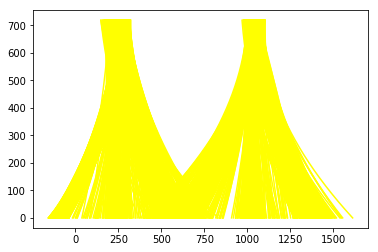

In [9]:
white_output = 'Project_video_out_5.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")#.subclip(20,21)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))